На сайте запущен А/В тест с целью увеличить доход.  
В приложенном excel файле вы найдете сырые данные  
по результатам эксперимента – user_id,  
тип выборки variant_name  
и доход принесенный пользователем revenue.

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [18]:
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy.stats import norm

import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [19]:
data = pd.read_excel('Lesson8_AB_Test_Results.xlsx')
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
1,2423,control,0.00
2,9411,control,0.00
3,7311,control,0.00
4,6174,variant,0.00
5,2380,variant,0.00
6,2849,control,0.00
7,9168,control,0.00
8,6205,variant,0.00
9,7548,control,0.00


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [21]:
data.shape

(10000, 3)

In [22]:
data.describe()

,USER_ID,REVENUE
count,"10,000.00","10,000.00"
mean,"4,981.08",0.10
std,"2,890.59",2.32
min,2.00,0.00
25%,"2,468.75",0.00
50%,"4,962.00",0.00
75%,"7,511.50",0.00
max,"10,000.00",196.01


In [23]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [24]:
new_data = data[data['REVENUE'] > 0]
new_data

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


In [25]:
new_data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,72.00,72.00
mean,"5,306.96",4.88
std,"3,116.54",9.91
min,56.00,0.02
25%,"2,707.50",1.25
50%,"5,721.00",2.17
75%,"7,963.75",3.97
max,"9,996.00",58.63


In [26]:
new_data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,80.00,80.00
mean,"4,461.95",8.04
std,"2,826.39",22.50
min,124.00,0.02
25%,"2,037.50",1.52
50%,"4,327.00",2.96
75%,"6,636.75",6.66
max,"9,766.00",196.01


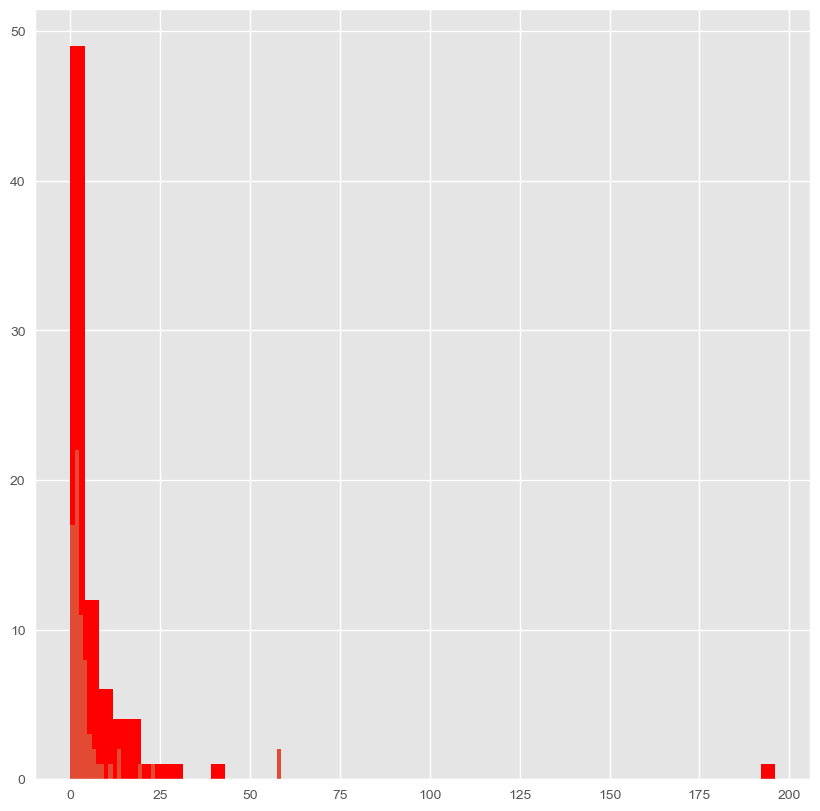

In [27]:
plt.figure(figsize=(10, 10))
control_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='control']
test_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()

In [28]:
ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=1.1379124979933528, pvalue=0.25760685398932337)

pvalue > 0.05  
Значимых изменений нет

In [29]:
print(kstest(control_visit_all, 'norm'))
print(kstest(test_visit_all, 'norm'))

KstestResult(statistic=0.7443502263331446, pvalue=3.4769340937348253e-46)
KstestResult(statistic=0.6885669682907651, pvalue=1.5788521734348758e-34)


pvalue < 0.05  
Отвергаем нулевую гипотезу данные распределенны не нормально

In [30]:
mannwhitneyu(control_visit_all, test_visit_all)

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

pvalue > 0.05  
Принимаем 0 гипотезу значемых изменений нет

In [31]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}


100%|██████████| 10000/10000 [00:02<00:00, 3831.37it/s]


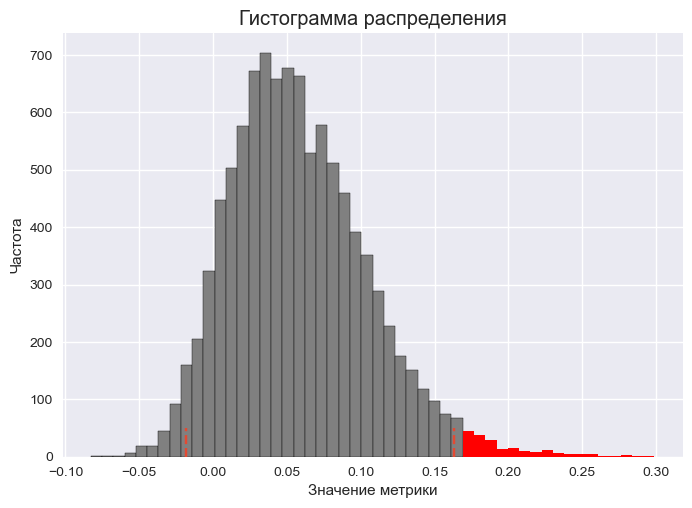

p_value 0.21193536869292962


In [32]:
plt.style.use('seaborn')
pd.options.display.float_format = '{:,.2f}'.format

booted_data = get_bootstrap(data['REVENUE'][data['VARIANT_NAME']=='control'],
                            data['REVENUE'][data['VARIANT_NAME']=='variant'],
                            boot_it = 10000)

print('p_value', booted_data['p_value'])

p_value > 0.05  
Нет статистической значимости  

Ответ: победил контрол раскатывать тест не нужно